In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from HPIB.HP4155 import HP4155
from HPIB.HPT import Plot, PlotVgs, PlotVp, CalcIsSat, SecDer, Plot2P
from HPIB.DevParams import UMC

from HPIB.INOSerial import Arduino

from LFDQ_instruments import KSA9000B
from LFDQ_instruments.addr import KSA9000B_addr

from IPython.display import clear_output, display
from os import makedirs, rename
from time import sleep
from datetime import datetime, timedelta

prepath = "C:/Users/Zucchi/Documents/Medidas/Teste/"
makedirs(prepath, exist_ok=True)

print("Import done")

Import done


In [ ]:
SM=Arduino("COM3")
print(SM.ask('*'.encode()))

In [3]:
from scipy.optimize import curve_fit

def lorentz(x, H, amp, cen, wid):
    return H + amp*wid**2/((x-cen)**2+wid**2)

def lorentz_fit(x, y):
    mean = sum(x * y) / sum(y)
    wid = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(lorentz, x, y, p0=[min(y), max(y), mean, wid], maxfev=10000)
    return popt

In [4]:
KSA=KSA9000B(KSA9000B_addr)

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [5]:
if True:
    HP=HP4155("GPIB0::17", debug=False)
    HP.reset()
    HP.IntTime="LONG"

    KSA=KSA9000B(KSA9000B_addr)
    SM=Arduino("COM3")
    print(SM.ask('*'.encode()))

HEWLETT-PACKARD,4155A,0,01.04:01.04:01.00


VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

# Test Vtune Estático

HP start
KSA start
KSA done


0

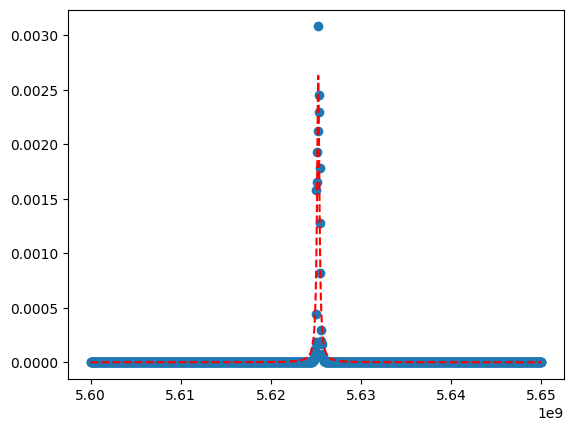

In [185]:
SM.opench(3)

HP.SetBiasVCO(Vt=6.85, Vcc=3.5)

HP.measure()

print("HP start")

KSA.f_start=5.6e9
KSA.f_stop=5.65e9
KSA.f_res=100e3
KSA.AvgCount=50
KSA.AvgMode=1
KSA.Continue=1


sleep(5)

KSA.Start()

sleep(1)
print("KSA start")

while not KSA.dataready():
        sleep(0.01)

print("KSA done")


df=KSA.get_data()

x=df['f']
y=df['dbm']

ylin=10**(y/10)

H, amp, cen, wid = lorentz_fit(x, ylin)

plt.plot(x, ylin, 'o')
plt.plot(x, lorentz(x, *lorentz_fit(x, ylin)), '--r', label='fit')

HP.stop()
# HP.get_data()

# Testes VCO #

In [72]:
HP.SetRampVCO(2, 5, 0.1, Vcc=3.3, HTime=2, DTime=3)

Set RampVCO
Vg=(2, 5, 0.1), Ilim=0.03


0

In [80]:
HP.measure()

0

In [7]:
HP.TriggerMode

'OUTP'

In [13]:
HP.TriggerEnable

'1'

In [74]:
HP.stop()

0

In [308]:
KSA.write("TRIG:SOUR BUS")

In [83]:
KSA.write("TRIG:SOUR EXT1")
KSA.AvgMode=0
KSA.Start()

print("not ready", end='')
while not KSA.dataready():
    print("+", end='')
    sleep(100e-3)
now=datetime.now()

KSA.write("TRIG:SOUR IMM")
KSA.AvgMode=1
KSA.Start()
print("\n measuring", end='')
while not KSA.dataready():
    print("+", end='')
    sleep(100e-3)

KSA.AvgMode=1
KSA.write("TRIG:SOUR EXT1")

df=KSA.get_data()

duration=datetime.now()-now
print(duration)

not ready++++
 measuring0:00:00.516640


Set RampVCO
Vg=(1, 10, 0.1), Ilim=0.03
250413 2100
Measuring 90/90
Done


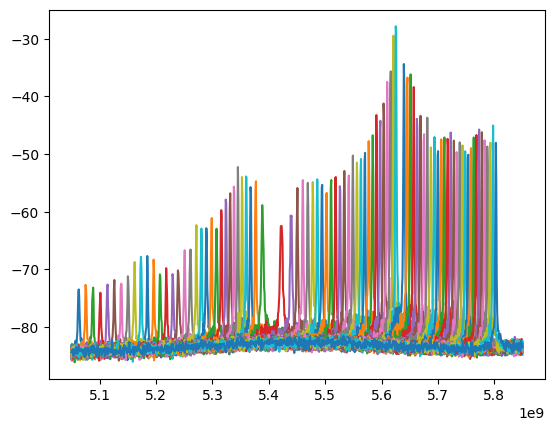

In [75]:
SM.opench(3)

HP.stop()
################# Measure Ramp ##################

path="C:/Users/Zucchi/Documents/Medidas/250408 TesteVCO/Cold"
makedirs(path, exist_ok=True)

HTime=2
DTime=3

VtStart=1
VtStop=10
VtStep=0.1

VtPoints=int((VtStop-VtStart)/VtStep)
HP.SetRampVCO(VtStart, VtStop, VtStep, Vcc=3.3, HTime=HTime, DTime=DTime)

KSA.f_start=5.05e9
KSA.f_stop=5.85e9
KSA.f_res=.5e6
KSA.AvgCount=100
KSA.AvgMode=1
KSA.Continue=1

now=datetime.now().strftime('%y%m%d %H%M')
print(now)

print(f"Measuring", end="")

V=[]
f_peak=[]
p_peak=[]

HP.measure()
start=datetime.now()

fig, ax=plt.subplots()

for i in range(VtPoints):
    Vtune=VtStart+VtStep*i 
    
    KSA.write("TRIG:SOUR EXT1")
    KSA.AvgMode=0
    KSA.Start()
    
    while not KSA.dataready():
        sleep(50e-3)
    
    KSA.write("TRIG:SOUR IMM")
    KSA.AvgMode=1
    KSA.Start()

    while not KSA.dataready():
        sleep(50e-3)

    sleep(50e-3)
    
    df=KSA.get_data()
    
    if i==0:
        freq_array=df['f']
        data_array=df['dbm']
    else:
        data_array=np.vstack((data_array, df['dbm']))

    ax.plot(df['f'], df['dbm'])
        
    V+=[Vtune]

    sleep(50e-3)
    KSA.AvgMode=0
    KSA.write("TRIG:SOUR EXT1")
    
    print(f"\rMeasuring {i}/{VtPoints}", end="")
        
print("\nDone")

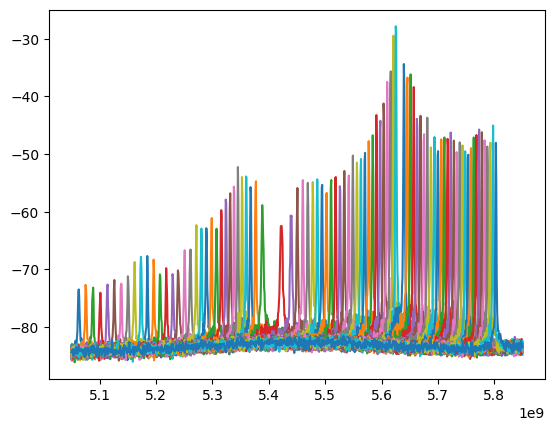

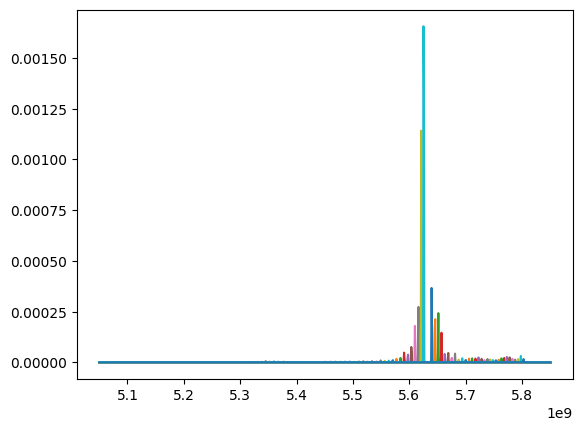

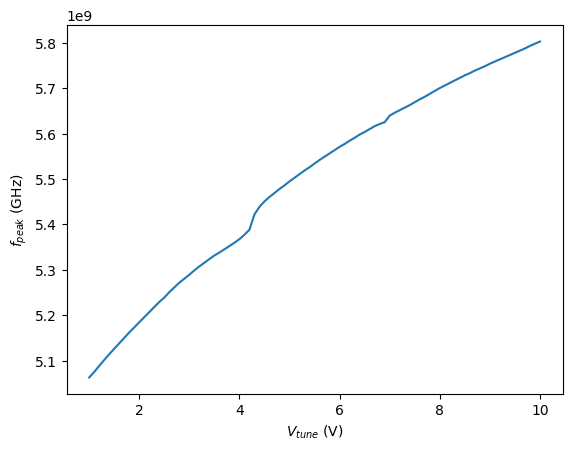

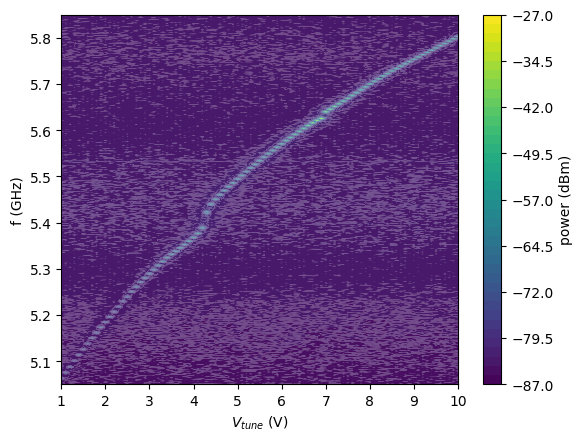

In [76]:
KSA.write("TRIG:SOUR IMM")
KSA.AvgMode=1

df_coarse=pd.DataFrame(data=np.transpose(np.vstack((np.transpose(freq_array), data_array))), columns=["f"]+[str(np.around(x, 2)) for x in V])
df_coarse.to_csv(f"{path}/{now} - Spectrum_data.csv")

fig, ax = plt.subplots()

fig2, ax2 = plt.subplots()

amp=np.empty(len(V))
cen=np.empty(len(V))
wid=np.empty(len(V))

for i, y in enumerate(data_array):
    ax.plot(freq_array, y)
    ylin=10**(y/10)
    ax2.plot(freq_array, ylin)

    # H, amp[i], cen[i], wid[i] = lorentz_fit(freq_array, ylin)

fig.savefig(f"{path}/{now} - Spectrum 2d.png")
fig2.savefig(f"{path}/{now} - Spectrum Linear 2d.png")

fig3, ax3 = plt.subplots()
f_peak=[freq_array[np.argmax(x)] for x in data_array]
ax3.plot(V, f_peak)
ax3.set_xlabel("$V_{tune}$ (V)")
ax3.set_ylabel("$f_{peak}$ (GHz)")
fig3.savefig(f"{path}/{now} - VxPeak.png")


fig4, ax4 = plt.subplots()

X, Y = np.meshgrid(freq_array*1e-9, V)

# Plot the surface.
CO = ax4.contourf(Y, X, data_array, 50, antialiased=True)

ax4.set_ylabel("f (GHz)")
ax4.set_xlabel("$V_{tune}$ (V)")
cbar = fig4.colorbar(CO)
cbar.ax.set_ylabel('power (dBm)')

fig4.savefig(f"{path}/{now} - Spectrum 3d.png")
plt.show()

In [ ]:
SM.opench(3)

HP.stop()
############### Measure Ramp ##############

VMax, fMax = np.transpose(np.where(data_array==np.max(data_array)))[0]

Vround=[np.around(x, 1) for x in V]

try:
    Vcenter=Vround[VMax]
    VtStart=Vcenter-0.5
    VtStop=Vcenter+0.5
    VtStep=0.05
    dist=0.2
    KSA.f_center=freq_array[fMax]
    KSA.f_span=100e6

except Exception as err:
    print (">>> Error:", err)
    Vcenter=8
    VtStart=Vcenter-1
    VtStop=Vcenter+1
    VtStep=0.025
    
    KSA.f_start=5.4e9
    KSA.f_stop=5.8e9

HTime=2
DTime=4


KSA.f_res=250e3
KSA.AvgCount=100
KSA.Continue=1

In [89]:
VtStep=0.025
VtPoints=int((VtStop-VtStart)/VtStep)
HP.SetRampVCO(VtStart, VtStop, VtStep, Vcc=3.3, HTime=HTime, DTime=DTime)

Set RampVCO
Vg=(6.4, 7.4, 0.025), Ilim=0.03


0

In [91]:
HP.stop()

KSA.f_span=100e6
KSA.f_res=250e3

now=datetime.now().strftime('%y%m%d %H%M')
print(now)

print(f"Measuring", end="")

V_fine=[]
peak_fine=[]

HP.measure()
start=datetime.now()

for i in range(VtPoints):
    Vtune=VtStart+VtStep*i 

    KSA.write("TRIG:SOUR EXT1")
    KSA.AvgMode=0
    KSA.Start()
    
    while not KSA.dataready():
        sleep(50e-3)
    
    KSA.write("TRIG:SOUR IMM")
    KSA.AvgMode=1
    KSA.Start()

    while not KSA.dataready():
        sleep(50e-3)

    sleep(50e-3)
    
    df=KSA.get_data()
    
    if i==0:
        freq_array=df['f']
        data_array=df['dbm']
    else:
        data_array=np.vstack((data_array, df['dbm']))

    ax.plot(df['f'], df['dbm'])
        
    V_fine+=[Vtune]

    sleep(50e-3)
    
    print(f"\rMeasuring {i}/{VtPoints}", end="")

KSA.write("TRIG:SOUR IMM")
KSA.AvgMode=1

print("\nDone")

250413 2123
Measuring 39/40
Done


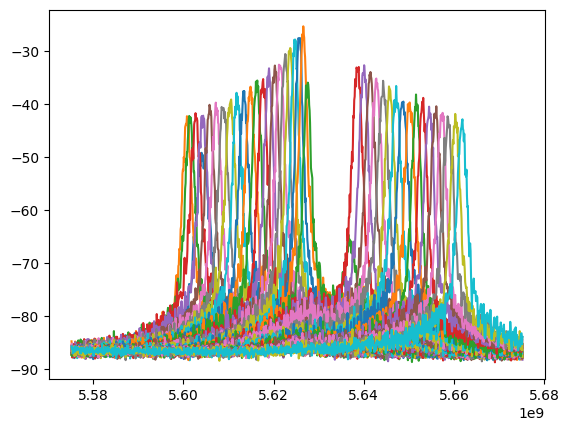

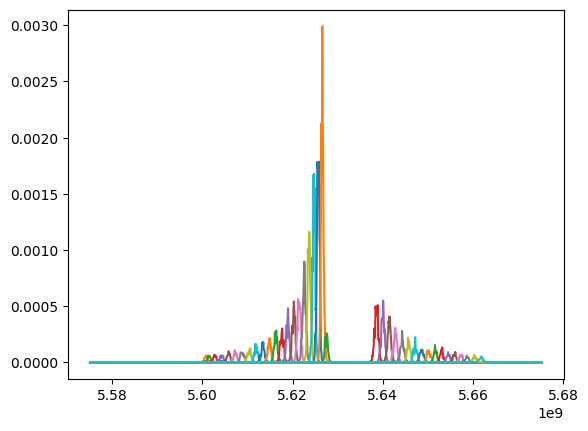

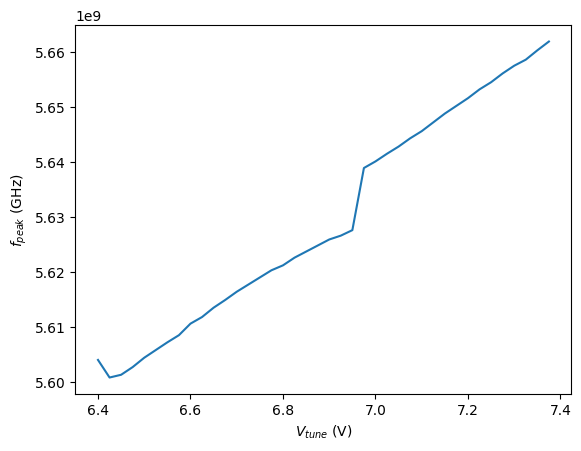

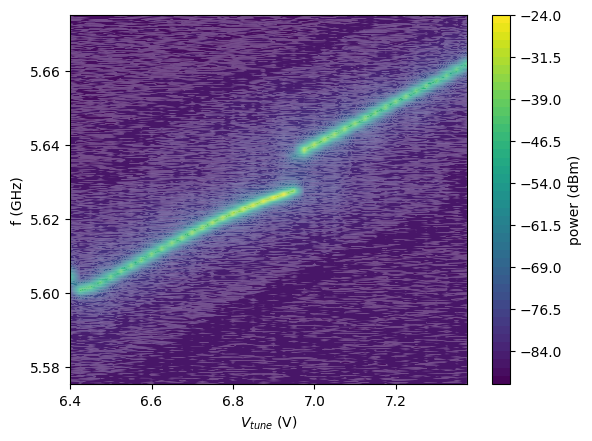

In [92]:
df=pd.DataFrame(data=np.transpose(np.vstack((np.transpose(freq_array), data_array))), columns=["f"]+[str(np.around(x, 2)) for x in V_fine])
df.to_csv(f"{path}/{now} - Spectrum_data.csv")

fig, ax = plt.subplots()

fig2, ax2 = plt.subplots()

amp=np.empty(len(V))
cen=np.empty(len(V))
wid=np.empty(len(V))

for i, y in enumerate(data_array):
    ax.plot(freq_array, y)
    ylin=10**(y/10)
    ax2.plot(freq_array, ylin)

    # H, amp[i], cen[i], wid[i] = lorentz_fit(freq_array, ylin)

fig.savefig(f"{path}/{now} - Spectrum 2d.png")
fig2.savefig(f"{path}/{now} - Spectrum Linear 2d.png")

fig3, ax3 = plt.subplots()
f_peak=[freq_array[np.argmax(x)] for x in data_array]
ax3.plot(V_fine, f_peak)
ax3.set_xlabel("$V_{tune}$ (V)")
ax3.set_ylabel("$f_{peak}$ (GHz)")
fig3.savefig(f"{path}/{now} - VxPeak.png")


fig4, ax4 = plt.subplots()

X, Y = np.meshgrid(freq_array*1e-9, V_fine)

# Plot the surface.
CO = ax4.contourf(Y, X, data_array, 50, antialiased=True)

ax4.set_ylabel("f (GHz)")
ax4.set_xlabel("$V_{tune}$ (V)")
cbar = fig4.colorbar(CO)
cbar.ax.set_ylabel('power (dBm)')

fig4.savefig(f"{path}/{now} - Spectrum 3d.png")
plt.show()

# Phase Noise

In [ ]:
###### Extrair phase noise

KSA.f_res=5e6
KSA.f_center=5e9
KSA.f_span=1e9

KSA.Start()
KSA.last_start=datetime.now()
while not KSA.dataready():
    sleep(0.01)
print(datetime.now()-KSA.last_start)
data=KSA.get_data()
plt.plot(data['f']*1e-9, data['dbm'])
plt.show()

In [ ]:
KSA.RefineMeasurement()

In [ ]:
KSA.Start()
sleep(2)
while not KSA.dataready():
    sleep(1)

peak_f=float(KSA.GetPeaks(-30, 0).split(',')[2])

KSA.f_res=1e3
KSA.f_center=5e9
KSA.f_span=100e3

KSA.Start()
sleep(2)
while not KSA.dataready():
    sleep(1)

#### Achar centro
peak_f=float(KSA.GetPeaks(-30, 0).split(',')[2])
KSA.f_start=peak_f-100
KSA.f_stop=peak_f+1100
KSA.f_res=100

peak_f=float(KSA.GetPeaks(-30, 0).split(',')[2])
KSA.f_start=peak_f-100
KSA.f_stop=peak_f+1100
KSA.f_res=10

In [ ]:
HP.close()
INO.close()
KSA.close()

del HP, INO, KSA

print("Comm closed")